# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Importar librerías de código

In [2]:
%reset
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.gridspec as gridspec
from sklearn import datasets

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#### Dataset que se va a utilizar para el entrenamiento

In [3]:
# Aquí deben de ir las instrucciones para obtener el Dataset que se va a usar en el entrenamiento.
digits = datasets.load_digits()
datos = digits.data
datos = datos.transpose()

# Valores de los pixeles de nuestro digito van de 0-16.
valor_min = 0
valor_max = 17

# Para saber el número de datos con los que vamos a trabajar y el numero de entradas que recibiran nuestra
# neurona podemos usar 'print(datos.shape)' para saber el tamaño de los datos y la cantidad de pixeles que
# usa cada dígito, al hacerlo obtenemos que son (64, 1797).
num_digitos = 1797 
num_pixeles = 64

## SOM Setup
#### Variables definidas por el alumno

In [4]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate.
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no.

lado_mapa = 30 # lado de la futura matriz de pesos.
periodo = 10000 # Número de veces que se va a repetir el ciclo de entrenamiento.
learning_rate = 0.1 # La neurona se desplazará un 10% al aprender.
normalizar_datos = True # Variable booleana que utilizamos más adelante.

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [5]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = num_pixeles
num_datos = num_digitos

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen.
vecindario = lado_mapa / 2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz.
if normalizar_datos:
    datos = datos / (valor_max-1)
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy.
matriz_pesos = np.random.random([lado_mapa, lado_mapa, num_entradas])

#### Funciones para entrenar/clasificar

Función calcular_bmu: En esta función, dado un patrón de entrada vamos a obtener la neurona ganadora y su posición. La neurona ganadora se calcula usando el criterio de la mínima distancia ecuclídea.

In [6]:
# Función para encontrar la BMU.
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
    
    # Incializamos las variables.
    dist = [0] * num_entradas
    bmu = [0] * num_entradas
    bmu_idx = [0] * 2
    
    # Tanto el for para las 'x' y para las 'y' sirven para recorrer la matriz de ancho y alto.
    for x in range (0, len(m_pesos[:, 0])):
        for y in range (0, len(m_pesos[0, :])):
            
            for z in range (0, m):
                # Calculamos una distancia euclidea para cada entrada. Obviamos la raiz cuadrada para ahorrarnos calculos.
                dist[z] = np.array((patron_entrada[z] - m_pesos[x, y, z])**2)
                
            # La distacia ecuclidea final será la suma de todas las distancias de las entradas de la neurona.
            distancia_euclidea = sum(dist)
            
            # Este if se ejecuta solo una vez y es para tener un primer mínimo con el que comparar el resto.
            if x == 0 and y == 0:
                
                # neurona_ganadora nos sirve para realizar comparaciones, cada vez que encontremos una distancia menor se 
                # actualizara el valor de la neurona ganadora con esa distancia.
                neurona_ganadora = distancia_euclidea
                # bmu es un vector que guarda la matriz de pesos de la neurona ganadora.
                bmu = np.array(m_pesos[x, y])
                # bmu_idx es un vector que guarda la posicion de la neurona ganadora.
                bmu_idx = np.array([x, y])
            
            # Si no es la primera vez que se ejecuta el if entraremos en el else y se hará una comparación.
            else:
                
                # Comparamos la distancia euclídea recién calculada con la que es nuestra neurona ganadora. Si es menor querrá
                # decir que hemos encontrado una neurona mejor.
                if distancia_euclidea < neurona_ganadora: 
                    
                    neurona_ganadora = distancia_euclidea
                    bmu = np.array(m_pesos[x, y])
                    bmu_idx = np.array([x, y])

    # Devolvemos los valores de la bmu y bmu_idx.
    return bmu, bmu_idx             

In [7]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta).
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    
    lr_final = 0
    learning_rate = lr_inicial + (((lr_final - lr_inicial) / n_iteraciones) * i)
    
    return learning_rate

In [8]:
# Función para calcular el descenso del vecindario (v).
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    
    lvecindario = int(1 + vecindario_inicial * (1 - (i / n_iteraciones)))
    
    return lvecindario

In [9]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU.
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    
    return np.exp(- distancia_BMU / (2 * (vecindario_actual**2)))

#### Funciones para dibujar la salida de la red

In [10]:
# Función para pintar una matriz de imagenes (números escritos a mano).
def pintar_mapa(matriz_valores):
    
    global etiqueta 
    
    print("Dibujando ...")

    plt.figure(figsize=(12, 12))
    index=1
    grid = gridspec.GridSpec(lado_mapa, lado_mapa)
    grid.update(wspace=0, hspace=0)
    matriz_valores = matriz_valores*16
    
    for i in range(matriz_valores.shape[0]):
        for j in range(matriz_valores.shape[1]):
            index = i * lado_mapa + j
            plt.subplot(grid[index])
            etiqueta=matriz_valores[i,j].reshape(8,8)
            plt.imshow(etiqueta, cmap='Greys')
            plt.axis('off')

In [11]:
def dibujar_digito(ejemplo):
    plt.figure(1, figsize=(1,1))
    plt.imshow(ejemplo.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

## SOM Entrenamiento

In [12]:
# Entrena la red con el dataset de entrenamiento.
# No imprimiremos la matriz de pesos ni la matriz de pesos entrenados.
# Tampoco dibujaremos el mapa de la matriz de pesos entrenados.

# Inicializamos las variables.
aleatorio = [0] * num_entradas

# Ejecutamos el entrenamiento tantas veces según el periodo.
for i in range (0, periodo):
    
    # Imprimimos cada 100 iteraciones el numero de iteración.
    if i%100 == 0:
        print('\nIteración: ', i)
        
    # Generamos el patron aleatorio para posteriormente calcular la bmu.
    numero = np.random.randint(0, num_datos - 1)
    for j in range (0, num_entradas):
        aleatorio[j]= datos[j][numero]
        
    # Buscamos la Best Matching Unit.
    bmu, bmu_idx = calcular_bmu(aleatorio, matriz_pesos, num_entradas)
    
    # Calculamos eta y v para cada interacción del bucle.
    eta = variacion_learning_rate(learning_rate, i, periodo)
    v = variacion_vecindario(vecindario, i, periodo)
    
    # Actualizamos los pesos de la neurona ganadora.
    matriz_pesos[bmu_idx[0], bmu_idx[1]] = bmu + eta * (aleatorio - bmu)
    
    # Actualizamos los pesos de las neuronas vecinas.
    for x in range (0, len(matriz_pesos[:, 0])):
        for y in range (0, len(matriz_pesos[0, :])):
            
            # Calculamos la distancia 2-D.
            distancia = ((bmu_idx[0] - x)**2) + ((bmu_idx[1] - y)**2)
            
            if distancia <= v :
                # Calculamos la amortiguación.
                amort = decay(distancia, v)
                # Actualizamos neuronas vecinas.
                matriz_pesos[x,y] = matriz_pesos[x,y] + (eta * amort) * (bmu-matriz_pesos[x,y])
                


Iteración:  0

Iteración:  100

Iteración:  200

Iteración:  300

Iteración:  400

Iteración:  500

Iteración:  600

Iteración:  700

Iteración:  800

Iteración:  900

Iteración:  1000

Iteración:  1100

Iteración:  1200

Iteración:  1300

Iteración:  1400

Iteración:  1500

Iteración:  1600

Iteración:  1700

Iteración:  1800

Iteración:  1900

Iteración:  2000

Iteración:  2100

Iteración:  2200

Iteración:  2300

Iteración:  2400

Iteración:  2500

Iteración:  2600

Iteración:  2700

Iteración:  2800

Iteración:  2900

Iteración:  3000

Iteración:  3100

Iteración:  3200

Iteración:  3300

Iteración:  3400

Iteración:  3500

Iteración:  3600

Iteración:  3700

Iteración:  3800

Iteración:  3900

Iteración:  4000

Iteración:  4100

Iteración:  4200

Iteración:  4300

Iteración:  4400

Iteración:  4500

Iteración:  4600

Iteración:  4700

Iteración:  4800

Iteración:  4900

Iteración:  5000

Iteración:  5100

Iteración:  5200

Iteración:  5300

Iteración:  5400

Iteración:  5500

Ite

## SOM Clasificación


Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.25, 0.75, 0.875, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.6875, 1.0, 1.0, 1.0, 0.1875, 0.0, 0.0, 0.1875, 1.0, 0.875, 0.125, 1.0, 0.4375, 0.0, 0.0, 0.5, 1.0, 0.4375, 0.0, 1.0, 0.375, 0.0, 0.0, 0.25, 1.0, 0.25, 0.1875, 1.0, 0.25, 0.0, 0.0, 0.25, 1.0, 0.3125, 0.625, 0.875, 0.0, 0.0, 0.0, 0.0, 0.875, 1.0, 1.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.25, 0.875, 0.875, 0.125, 0.0, 0.0]
x =  3
y =  12

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0625, 0.8125, 1.0, 1.0, 0.3125, 0.0, 0.0, 0.0, 0.4375, 0.625, 0.25, 0.625, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.9375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.75, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.1875, 0.0625, 0.3125, 0.1875, 0.0, 0.0, 0.0625, 0.9375, 1.0, 1.0, 0.9375, 0.1875, 0.0]
x =  14
y =  29

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0, 0.3125, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.87

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.4375, 1.0, 0.9375, 0.25, 0.0, 0.0, 0.0, 0.0, 0.6875, 1.0, 0.9375, 0.75, 0.0, 0.0, 0.0, 0.0, 0.3125, 1.0, 1.0, 0.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.5, 0.9375, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.6875, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.3125, 0.9375, 0.5625, 0.0, 0.0, 0.0, 0.375, 0.9375, 1.0, 1.0, 0.125, 0.0]
x =  6
y =  18

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0, 0.3125, 0.8125, 1.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.9375, 0.375, 0.4375, 0.875, 0.0, 0.0, 0.125, 1.0, 0.0625, 0.0625, 0.6875, 0.625, 0.0, 0.0, 0.25, 1.0, 0.9375, 1.0, 1.0, 0.375, 0.0, 0.0, 0.0, 0.25, 0.25, 0.3125, 0.9375, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5625, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.9375, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.625, 0.0, 0.0, 0.0]
x =  14
y =  21

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0625, 0.75, 1.0, 1.0, 0.5625, 0.0, 0.0, 0.0, 0.125, 0.875, 0.

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0625, 0.625, 0.5625, 0.6875, 0.3125, 0.0, 0.0, 0.0625, 0.875, 0.5, 0.0625, 0.125, 0.6875, 0.0, 0.0, 0.0, 0.875, 0.1875, 0.0, 0.6875, 0.3125, 0.0, 0.0, 0.0, 0.125, 0.75, 0.75, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.9375, 0.875, 0.25, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.3125, 0.0625, 0.75, 0.125, 0.0, 0.0, 0.0, 0.8125, 0.0, 0.0, 0.875, 0.125, 0.0, 0.0, 0.0, 0.5625, 0.8125, 1.0, 0.5625, 0.0, 0.0]
x =  6
y =  25

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.1875, 0.8125, 1.0, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.875, 0.75, 0.875, 1.0, 0.0625, 0.0, 0.0, 0.0, 0.375, 0.0, 0.4375, 0.9375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.5, 0.8125, 1.0, 0.875, 0.25, 0.0, 0.0, 0.3125, 1.0, 1.0, 0.875, 0.75, 0.25, 0.0, 0.0, 0.0, 0.1875, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.8125, 0.0, 0.0, 0.0, 0.0]
x =  22
y =  17

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.625, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,


Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.125, 0.875, 0.8125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.75, 0.8125, 0.75, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.375, 0.375, 1.0, 0.25, 0.0, 0.0, 0.0, 0.3125, 1.0, 0.9375, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.125, 0.25, 0.6875, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.5625, 0.0, 0.0, 0.125, 0.8125, 0.4375, 0.0625, 0.6875, 0.625, 0.0, 0.0, 0.0, 0.125, 0.625, 0.9375, 1.0, 0.125, 0.0]
x =  5
y =  19

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0625, 0.8125, 0.875, 0.0625, 0.0, 0.0, 0.0, 0.0625, 0.6875, 1.0, 0.625, 0.75, 0.0, 0.0, 0.0, 0.375, 1.0, 0.9375, 0.0, 0.8125, 0.1875, 0.0, 0.0, 0.4375, 0.875, 0.3125, 0.0, 0.5, 0.5625, 0.0, 0.0, 0.375, 0.8125, 0.0, 0.0, 0.5, 0.6875, 0.0, 0.0, 0.25, 0.9375, 0.0, 0.0625, 0.875, 0.5625, 0.0, 0.0, 0.0, 0.875, 0.5, 0.75, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.1875, 0.9375, 0.9375, 0.25, 0.0, 0.0]
x =  3
y =  13

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.125, 0.625, 0.625, 0.75, 0.937

x =  0
y =  7

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.375, 1.0, 1.0, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.75, 0.9375, 0.625, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.375, 0.8125, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 0.9375, 0.375, 0.0, 0.0, 0.0, 0.0625, 0.5625, 0.875, 0.5, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.625, 0.0, 0.0, 0.0, 0.0]
x =  16
y =  17

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0, 0.8125, 0.8125, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5625, 1.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8125, 1.0, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.125, 1.0, 1.0, 0.875, 0.5, 0.0625, 0.0, 0.0, 0.25, 1.0, 1.0, 0.375, 1.0, 0.5625, 0.0, 0.0, 0.0, 0.5, 1.0, 0.6875, 1.0, 0.625, 0.0, 0.0, 0.0, 0.0625, 0.875, 1.0, 0.8125, 0.0625, 0.0]
x =  11
y =  8

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.25, 0.75, 1.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.5625, 0.43


Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0625, 0.625, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.8125, 0.625, 1.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0625, 0.25, 1.0, 0.0625, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.8125, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5625, 0.75, 0.0, 0.0, 0.0, 0.0, 0.125, 0.8125, 0.9375, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.25, 0.9375, 0.875, 0.4375, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.6875, 0.875, 0.9375, 0.3125, 0.0]
x =  21
y =  23

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.1875, 0.8125, 1.0, 0.3125, 0.0, 0.0, 0.0, 0.375, 0.9375, 0.5625, 0.9375, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 1.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.875, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.5625, 1.0, 1.0, 0.875, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.125, 0.9375, 0.625, 0.0, 0.0, 0.0, 0.25, 0.3125, 0.75, 1.0, 0.875, 0.0, 0.0, 0.0, 0.3125, 0.8125, 0.875, 0.5, 0.125, 0.0]
x =  9
y =  19

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0625, 0.6875, 1.0, 1.0, 0.25, 0.0, 0.0,

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.125, 0.875, 0.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 1.0, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 1.0, 0.5, 0.25, 0.125, 0.0, 0.0, 0.0, 0.25, 1.0, 1.0, 1.0, 0.9375, 0.1875, 0.0, 0.0, 0.125, 1.0, 0.75, 0.25, 0.375, 1.0, 0.125, 0.0, 0.0, 0.8125, 0.5, 0.1875, 0.375, 1.0, 0.375, 0.0, 0.0, 0.125, 0.8125, 0.875, 1.0, 0.75, 0.0625]
x =  13
y =  9

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.625, 1.0, 1.0, 0.4375, 0.0, 0.0, 0.0, 0.375, 0.9375, 0.5625, 0.875, 0.75, 0.0, 0.0, 0.0, 0.1875, 0.3125, 0.0, 0.8125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.8125, 0.6875, 0.5, 0.1875, 0.0, 0.0, 0.0, 0.75, 1.0, 1.0, 1.0, 0.3125, 0.0]
x =  14
y =  29

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.125, 1.0, 0.8125, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.375, 0.9375, 1.0, 0.4

x =  0
y =  28

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.5, 0.875, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.875, 0.8125, 0.5, 0.5, 0.0, 0.0, 0.0, 0.125, 1.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 1.0, 0.8125, 1.0, 0.8125, 0.0, 0.0, 0.0, 0.1875, 1.0, 1.0, 0.75, 1.0, 0.4375, 0.0, 0.0, 0.0, 0.25, 0.0625, 0.125, 0.875, 0.375, 0.0, 0.0, 0.0, 0.0625, 0.375, 1.0, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.9375, 0.5, 0.0625, 0.0, 0.0]
x =  0
y =  19

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.375, 0.875, 0.875, 0.8125, 0.6875, 0.0, 0.0, 0.0, 0.875, 0.75, 0.3125, 0.25, 0.125, 0.0, 0.0, 0.1875, 1.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.125, 0.6875, 0.6875, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.4375, 0.75, 0.5, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.875, 0.6875, 0.0625, 0.0, 0.0]
x =  0
y =  20

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0, 0.125, 0.5625, 0.8125, 0.375, 0.0, 0.0

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.375, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.8125, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.125, 0.75, 0.625, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5625, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.625, 1.0, 0.625, 0.5, 0.1875, 0.0, 0.0, 0.25, 1.0, 1.0, 0.9375, 1.0, 1.0]
x =  14
y =  15

Coordenas de la BMU para el patrón de prueba  [0.0, 0.3125, 1.0, 0.75, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.875, 0.9375, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.875, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 1.0, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 1.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.125, 0.875, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6875, 1.0, 0.5625, 0.5, 0.5, 0.1875, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.25, 0.0]
x =  14
y =  28

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.25, 0.75, 0.625, 0.0625, 0.0, 0.0, 0.0, 0.1875, 1.0, 0.8125, 0.9375, 0.625, 0.0, 0.

y =  10

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0625, 0.875, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.125, 0.625, 0.3125, 0.875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.4375, 0.9375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 1.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.875, 0.25, 0.0, 0.0, 0.0, 0.8125, 0.0, 0.0, 0.25, 0.75, 0.0, 0.0, 0.0, 0.8125, 0.375, 0.25, 0.5, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.75, 1.0, 0.9375, 0.375, 0.0]
x =  10
y =  14

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.4375, 0.6875, 0.9375, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.9375, 0.25, 0.6875, 0.25, 0.0, 0.0, 0.1875, 0.6875, 0.3125, 0.0, 0.125, 0.625, 0.0, 0.0, 0.4375, 0.5, 0.0, 0.0, 0.1875, 0.5, 0.0, 0.0, 0.375, 0.5, 0.0, 0.0, 0.25, 0.5, 0.0, 0.0, 0.3125, 0.5, 0.0, 0.0, 0.5, 0.3125, 0.0, 0.0, 0.0625, 0.75, 0.125, 0.0625, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.3125, 1.0, 0.875, 0.1875, 0.0, 0.0]
x =  0
y =  14

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.0625, 0.75, 1.0, 0.875, 0.125, 0.0, 0.0, 0

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.5, 0.9375, 0.9375, 0.125, 0.0, 0.0, 0.0, 0.125, 1.0, 0.8125, 0.75, 0.625, 0.0, 0.0, 0.0, 0.1875, 0.9375, 0.0625, 0.5625, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.9375, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.8125, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.375, 1.0, 1.0, 0.8125, 0.4375, 0.375, 0.0625, 0.0, 0.0, 0.4375, 0.3125, 0.75, 1.0, 0.9375, 0.125]
x =  12
y =  26

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0, 0.25, 0.5625, 0.8125, 0.3125, 0.0, 0.0, 0.0, 0.0625, 1.0, 1.0, 0.75, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.5, 0.3125, 1.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.625, 0.8125, 0.625, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.9375, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6875, 0.5625, 0.875, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 1.0, 0.5, 0.0, 0.0]
x =  21
y =  24

Coordenas de la BMU para el patrón de prueba  [0.0, 0.0625, 0.5625, 1.0, 0.8125, 0.4375, 0.0, 0.0, 0.0

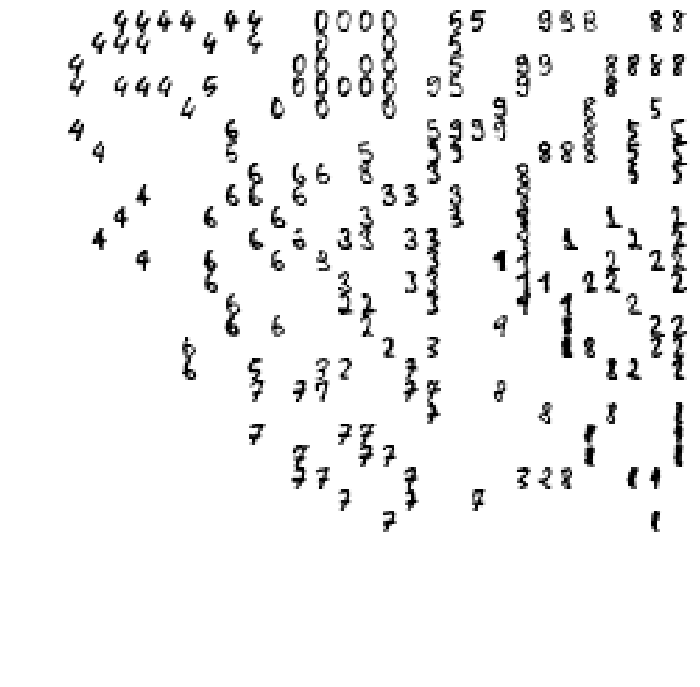

In [13]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada.

# Inicializamos las variables.
# Definimos tres matrices y las inicializamos a 0.
mapa_de_clasificacion = np.zeros((lado_mapa, lado_mapa, num_entradas))
mapa_de_activacion = np.zeros((lado_mapa, lado_mapa))
mapa_de_distancias = np.zeros((lado_mapa, lado_mapa))


random = [0] * num_entradas
distancia_media_patrones = [0] * num_entradas
cont_neuronas_activadas = 0

# Recorremos todo el dataset con la matriz de pesos.
for x in range (0, len(matriz_pesos[:, 0])):
    for y in range (0, len(matriz_pesos[0, :])):
        
        # Generamos el numero aleatorio.
        numero = np.random.randint(0, num_datos - 1)
        
        # Cojemos una posición aleatoria de datos yla guardamos en random[i].
        for i in range (0, num_entradas):
            random[i] = datos[i][numero]
        
        # Obtenemos el patron de la bmu ganadora y su posición en la matriz.
        bmu, bmu_idx = calcular_bmu(random, matriz_pesos, num_entradas)
        
        # Imprimimos las cordenadas (x, y) de la BMU para cada patrón de prueba.
        print('\nCoordenas de la BMU para el patrón de prueba ', random)
        print('x = ', bmu_idx[0])
        print('y = ', bmu_idx[1])
        
        # Calculamos un mapa con los sumatorios de distancias medias. ATENCION: este no es el mapa_de_distancias. 
        # Calculamos la distancia.
        distancia_media_patrones = sum((bmu - random)**2)
        # Guardamos la distancia calculada en un mapa de distancias, en el caso de que es esa posición ya hubiera guardada
        # una distancia anterior, sumariamos la distancia calculada a la que ya habia guardada en dicho mapa.
        mapa_de_distancias[bmu_idx[0], bmu_idx[1]] = mapa_de_distancias[bmu_idx[0], bmu_idx[1]] + distancia_media_patrones
        # Este mapa no es el verdadero mapa_de_distancias pero lo será cuando lo acabemos de calcular más adelante.
       
        # Calculamos el mapa de clasificación.
        mapa_de_clasificacion[bmu_idx[0], bmu_idx[1]] = random
       
        # Calculamos el mapa de activación.
        mapa_de_activacion[bmu_idx[0], bmu_idx[1]] += 1


# Una vez terminado el for, tenemos creado bien el mapa_de_activacion y podemos usarlo para hacer la media de nuestras
# distancias en el mapa_de_distancias.
# Mapa de distancias.
for x in range (0, len(matriz_pesos[:, 0])):
    for y in range (0, len(matriz_pesos[0, :])):
        if mapa_de_activacion[x][y] > 0:
            mapa_de_distancias[x][y] = mapa_de_distancias[x][y] / mapa_de_activacion[x][y]
            # Contamos las neuronas que han sido activadas.
            cont_neuronas_activadas = cont_neuronas_activadas + 1
        else:
            mapa_de_distancias[x][y] = 0        


# Imprimimos los mapas de activación y de distancias.
print('\n\nMapa de activaciones: \n')
print(mapa_de_activacion)
print('\n\nMapa de distancias: \n')
print(mapa_de_distancias)

# Calculamos la distancia media del mapa (solo para aquellas neuronas activadas)
distancia_media_neuronas_activadas = sum(sum(mapa_de_distancias)) / cont_neuronas_activadas

# Imprimimos la distancia media
print('\n\nDistancia media del mapa: ', distancia_media_neuronas_activadas)

# Dibujamos el mapa de clasificación.
print('\n\nMapa de clasificacion')
pintar_mapa(mapa_de_clasificacion)

## SOM Prueba


Coordenas de la BMU para el patrón de prueba  [ 0  0  9 15 14  2  0  0  0  0  9  3  9  8  0  0  0  0  0  0  6 10  0  0  0
  0  0 10 15  2  0  0  0  0  2 10 11 15  2  0  0  3  1  0  0 14  4  0  0 10
 13  7  2 12  4  0  0  0  7 14 16 10  0  0]
x =  25
y =  12

Coordenas de la BMU para el patrón de prueba  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x =  14
y =  12

Coordenas de la BMU para el patrón de prueba  [ 0  0  3 13 13  3  0  0  0  0 14  8  7 15  1  0  0  3 16  0  0  9  6  0  0
  6 13  0  0  4  8  0  0  4  9  0  0  4  8  0  0  1 13  0  0  5  8  0  0  0
 14  7  0 11  4  0  0  0  3 15 16 14  0  0]
x =  3
y =  15

Coordenas de la BMU para el patrón de prueba  [ 0  1  6 12 15  5  0  0  0  7 14 14 16  7  0  0  0  0  2 14 10  0  0  0  0
  0 11 16  2  0  0  0  0  0  2 11 16 12  0  0  0  0  0  0  4 14  7  0  0  0
  2  4  5 14  7  0  0  0  6 16 14  8  0  0]
x =  25
y =  12

Coordenas de la BMU para el p

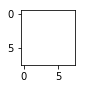

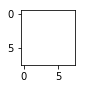

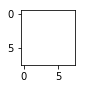

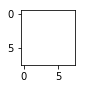

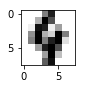

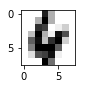

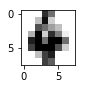

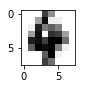

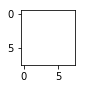

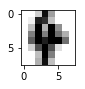

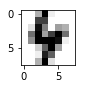

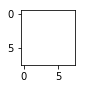

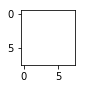

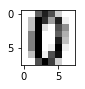

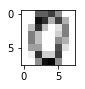

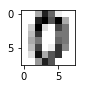

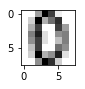

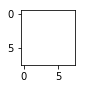

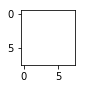

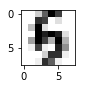

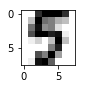

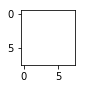

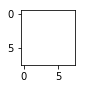

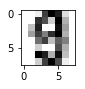

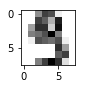

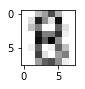

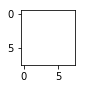

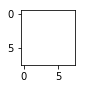

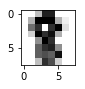

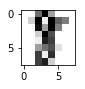

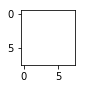

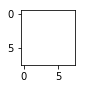

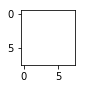

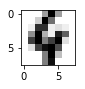

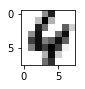

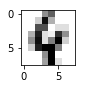

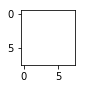

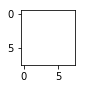

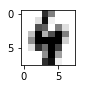

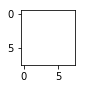

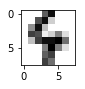

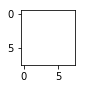

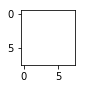

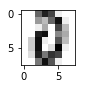

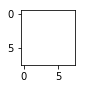

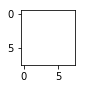

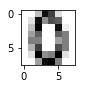

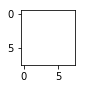

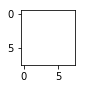

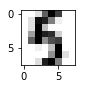

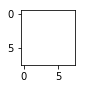

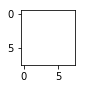

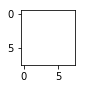

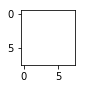

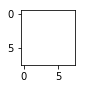

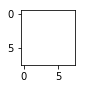

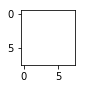

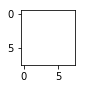

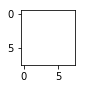

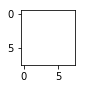

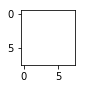

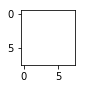

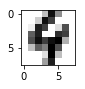

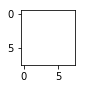

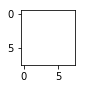

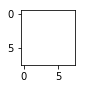

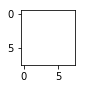

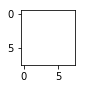

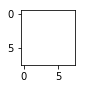

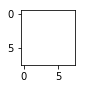

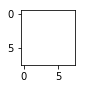

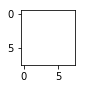

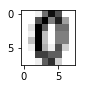

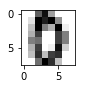

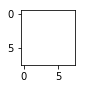

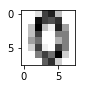

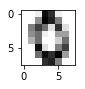

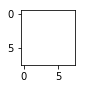

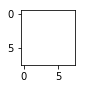

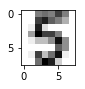

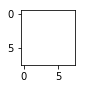

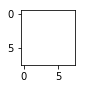

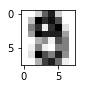

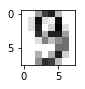

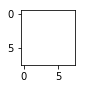

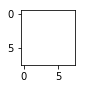

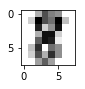

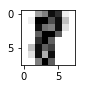

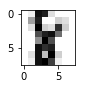

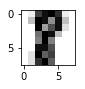

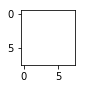

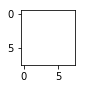

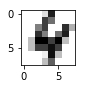

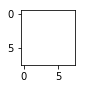

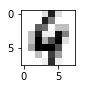

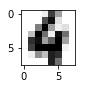

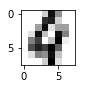

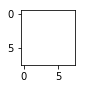

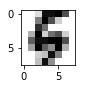

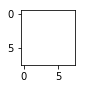

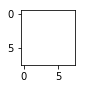

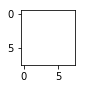

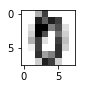

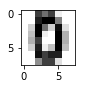

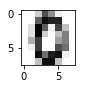

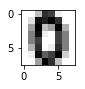

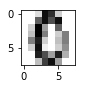

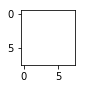

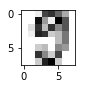

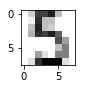

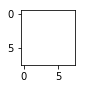

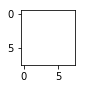

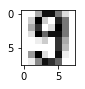

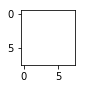

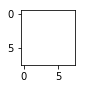

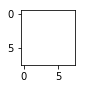

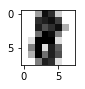

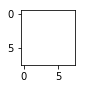

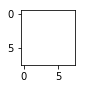

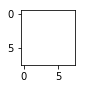

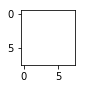

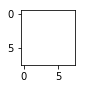

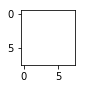

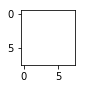

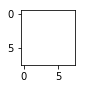

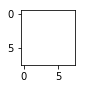

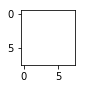

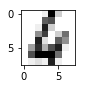

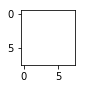

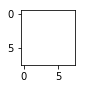

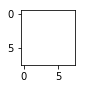

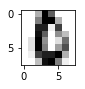

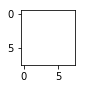

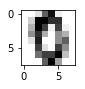

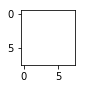

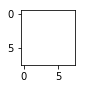

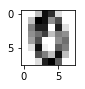

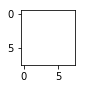

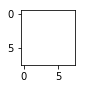

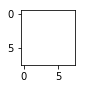

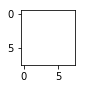

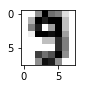

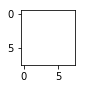

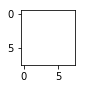

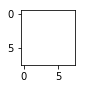

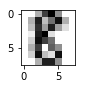

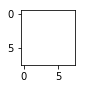

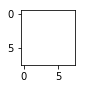

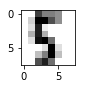

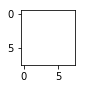

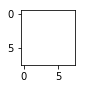

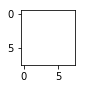

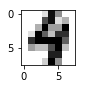

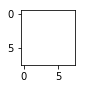

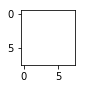

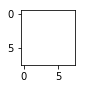

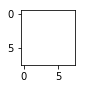

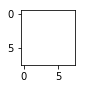

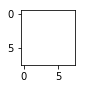

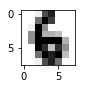

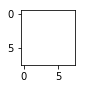

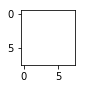

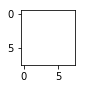

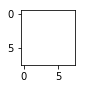

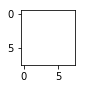

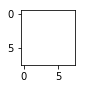

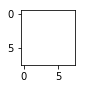

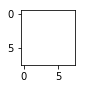

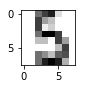

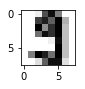

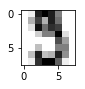

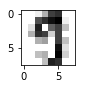

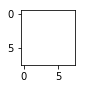

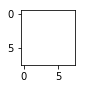

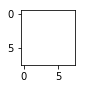

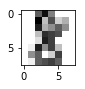

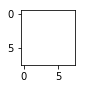

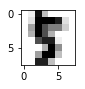

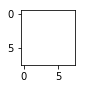

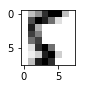

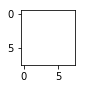

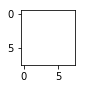

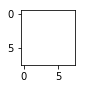

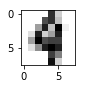

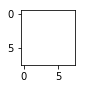

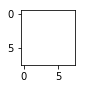

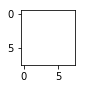

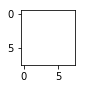

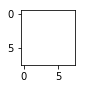

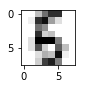

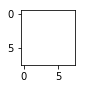

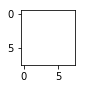

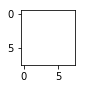

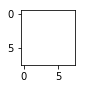

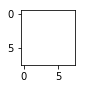

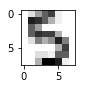

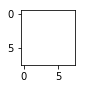

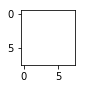

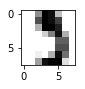

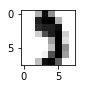

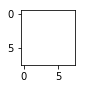

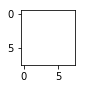

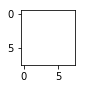

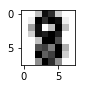

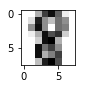

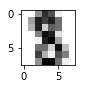

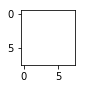

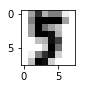

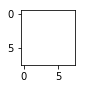

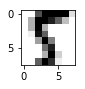

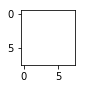

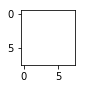

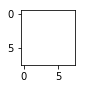

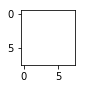

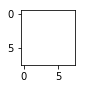

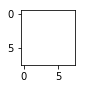

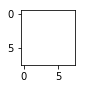

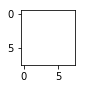

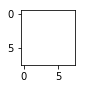

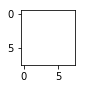

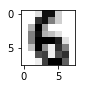

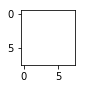

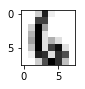

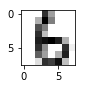

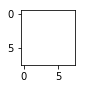

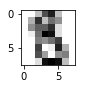

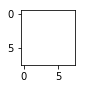

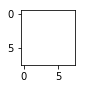

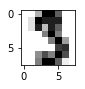

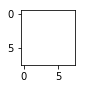

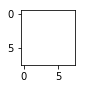

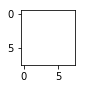

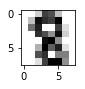

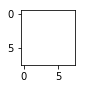

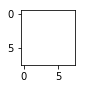

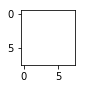

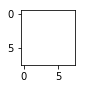

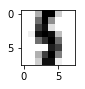

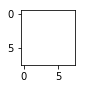

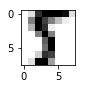

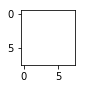

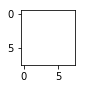

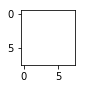

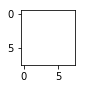

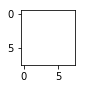

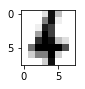

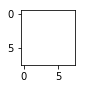

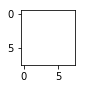

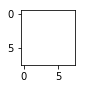

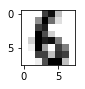

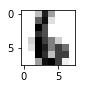

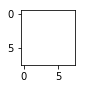

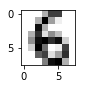

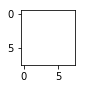

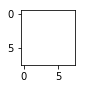

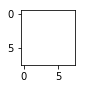

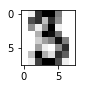

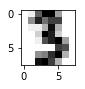

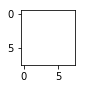

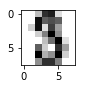

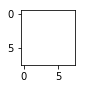

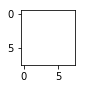

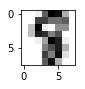

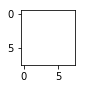

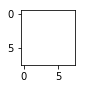

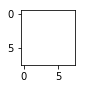

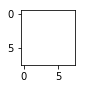

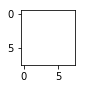

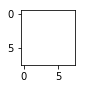

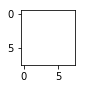

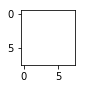

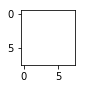

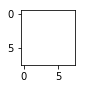

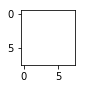

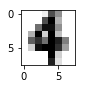

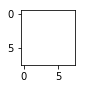

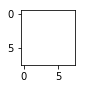

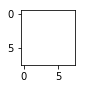

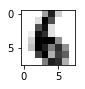

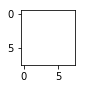

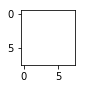

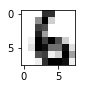

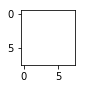

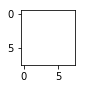

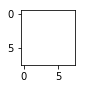

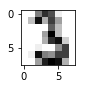

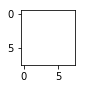

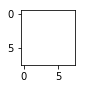

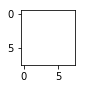

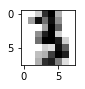

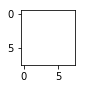

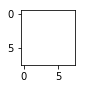

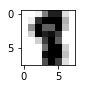

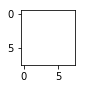

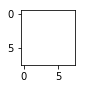

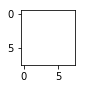

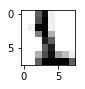

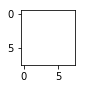

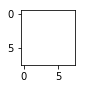

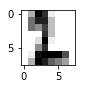

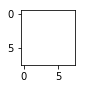

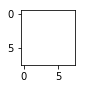

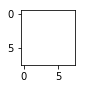

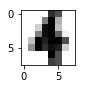

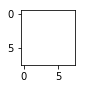

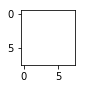

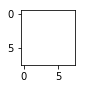

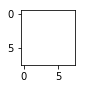

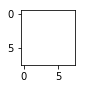

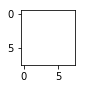

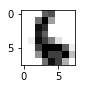

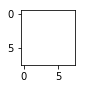

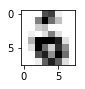

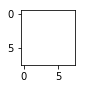

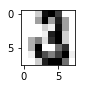

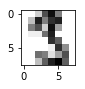

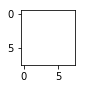

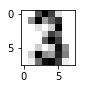

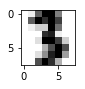

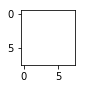

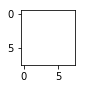

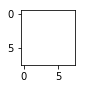

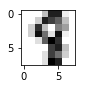

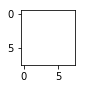

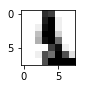

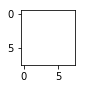

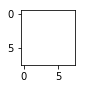

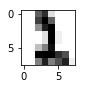

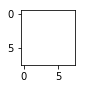

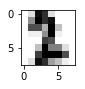

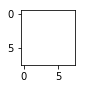

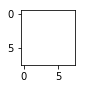

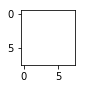

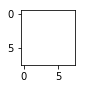

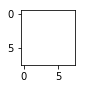

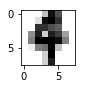

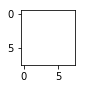

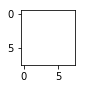

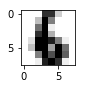

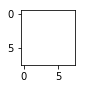

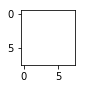

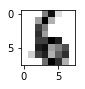

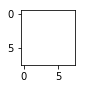

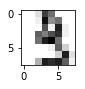

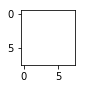

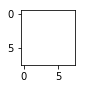

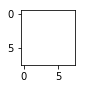

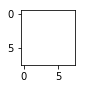

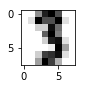

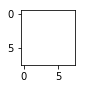

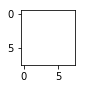

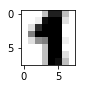

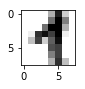

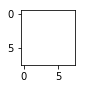

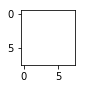

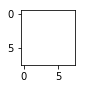

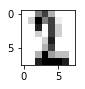

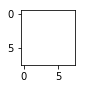

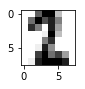

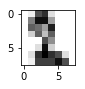

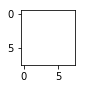

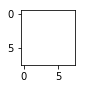

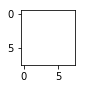

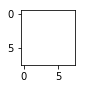

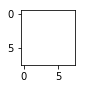

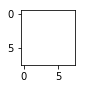

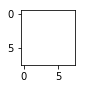

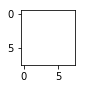

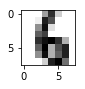

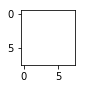

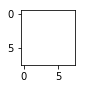

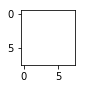

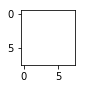

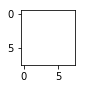

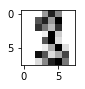

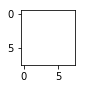

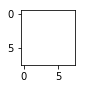

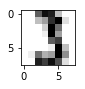

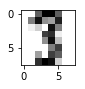

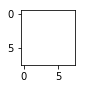

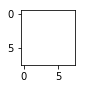

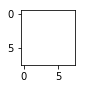

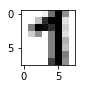

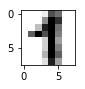

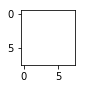

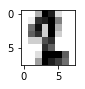

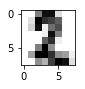

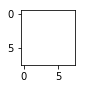

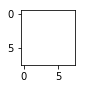

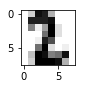

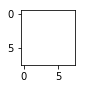

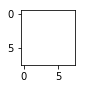

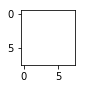

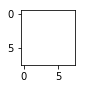

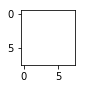

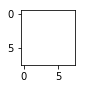

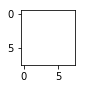

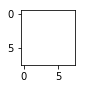

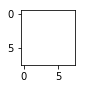

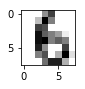

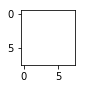

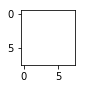

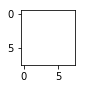

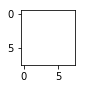

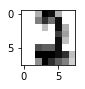

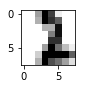

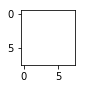

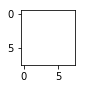

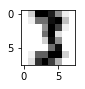

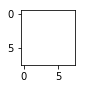

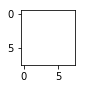

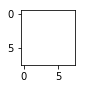

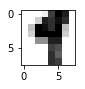

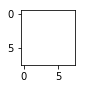

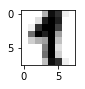

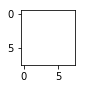

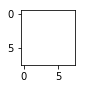

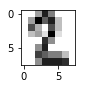

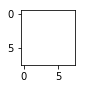

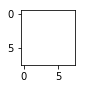

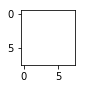

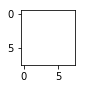

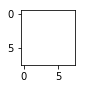

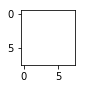

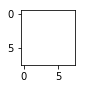

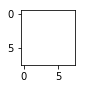

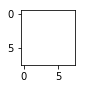

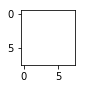

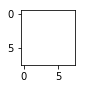

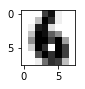

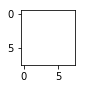

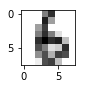

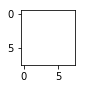

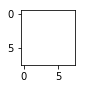

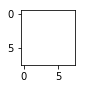

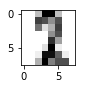

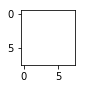

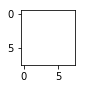

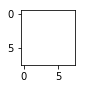

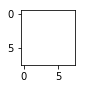

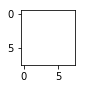

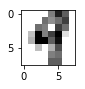

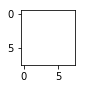

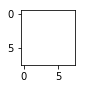

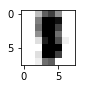

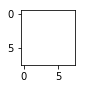

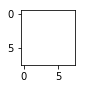

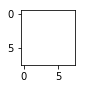

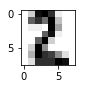

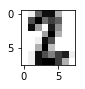

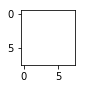

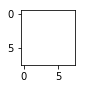

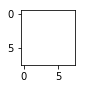

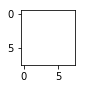

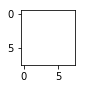

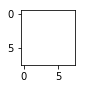

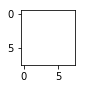

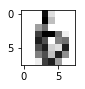

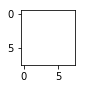

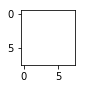

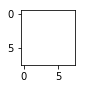

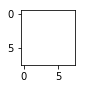

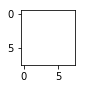

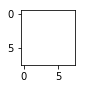

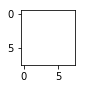

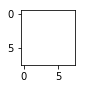

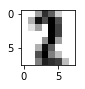

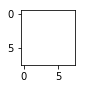

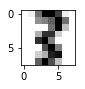

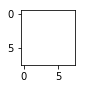

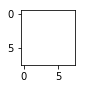

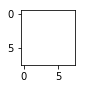

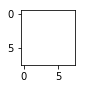

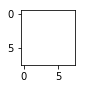

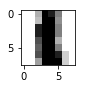

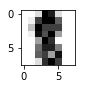

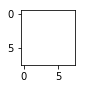

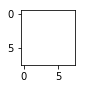

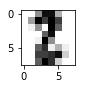

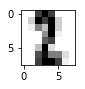

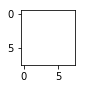

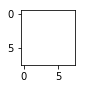

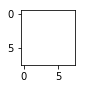

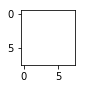

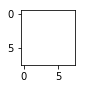

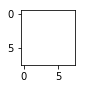

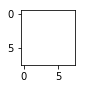

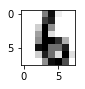

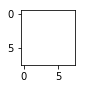

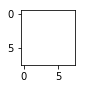

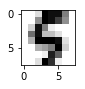

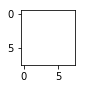

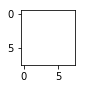

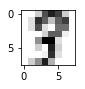

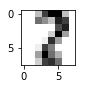

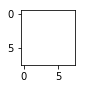

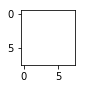

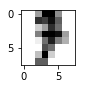

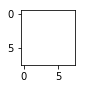

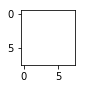

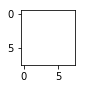

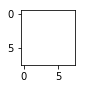

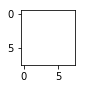

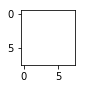

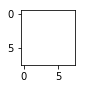

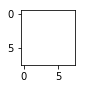

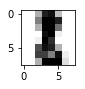

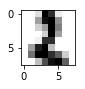

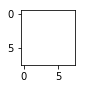

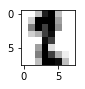

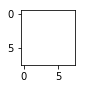

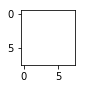

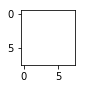

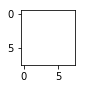

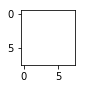

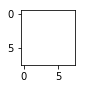

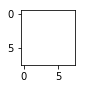

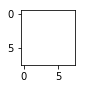

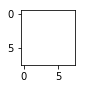

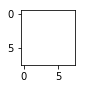

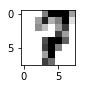

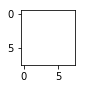

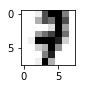

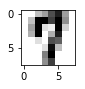

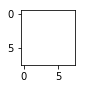

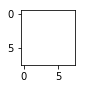

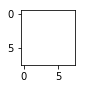

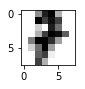

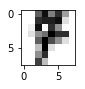

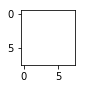

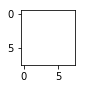

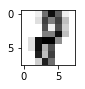

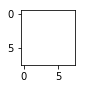

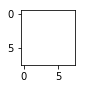

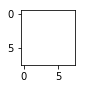

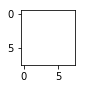

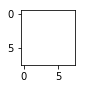

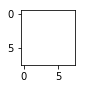

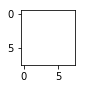

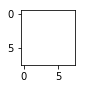

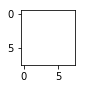

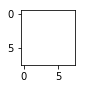

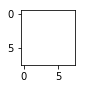

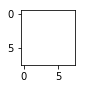

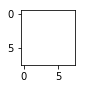

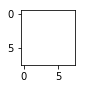

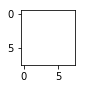

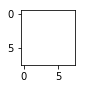

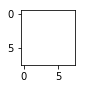

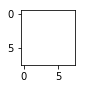

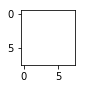

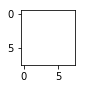

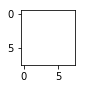

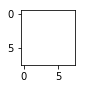

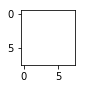

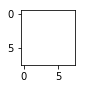

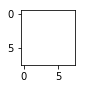

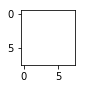

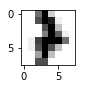

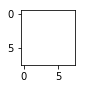

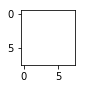

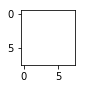

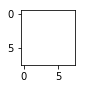

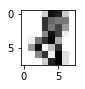

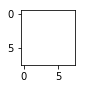

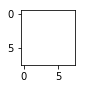

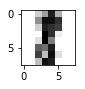

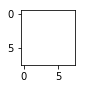

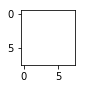

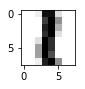

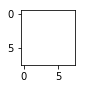

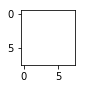

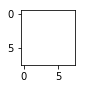

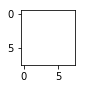

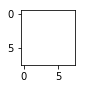

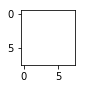

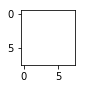

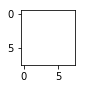

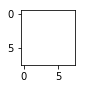

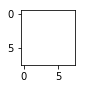

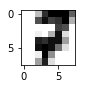

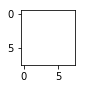

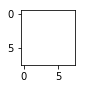

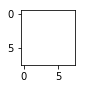

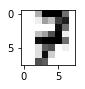

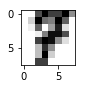

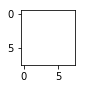

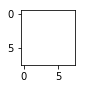

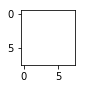

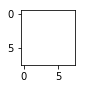

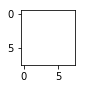

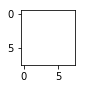

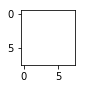

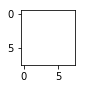

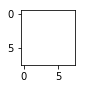

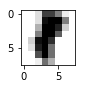

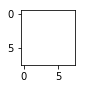

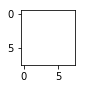

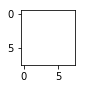

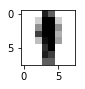

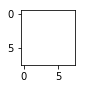

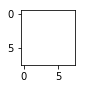

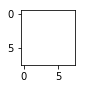

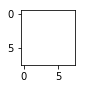

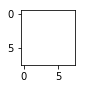

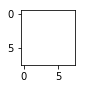

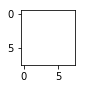

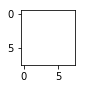

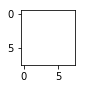

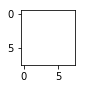

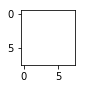

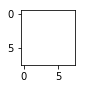

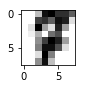

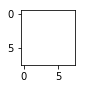

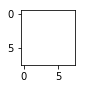

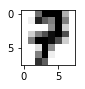

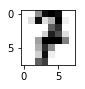

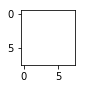

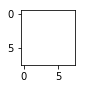

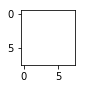

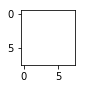

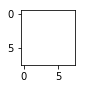

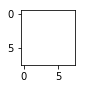

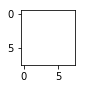

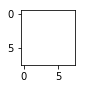

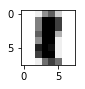

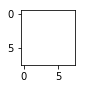

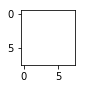

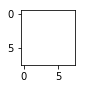

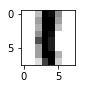

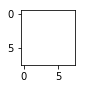

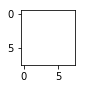

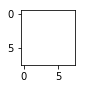

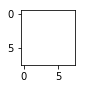

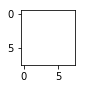

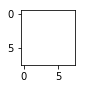

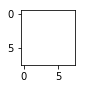

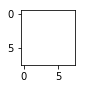

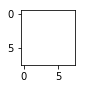

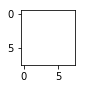

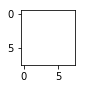

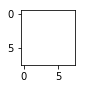

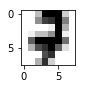

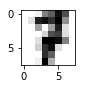

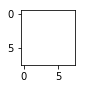

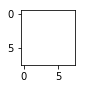

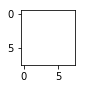

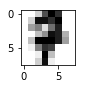

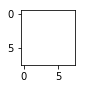

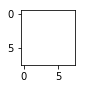

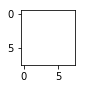

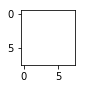

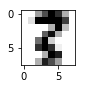

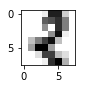

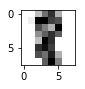

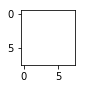

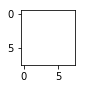

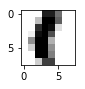

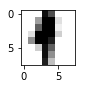

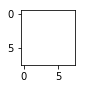

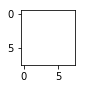

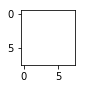

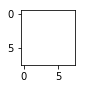

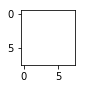

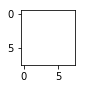

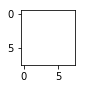

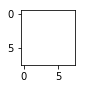

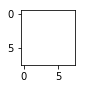

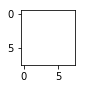

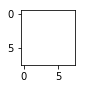

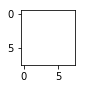

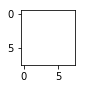

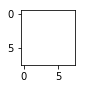

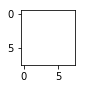

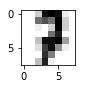

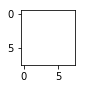

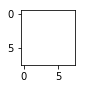

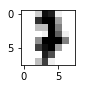

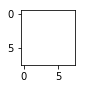

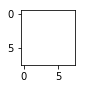

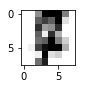

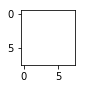

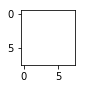

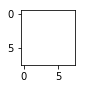

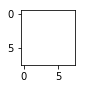

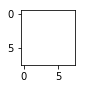

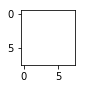

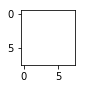

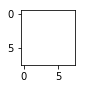

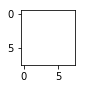

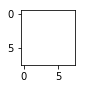

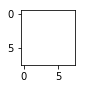

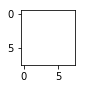

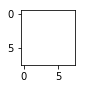

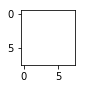

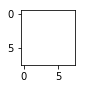

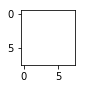

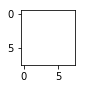

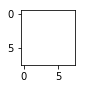

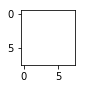

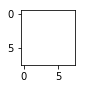

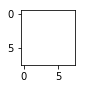

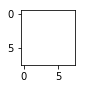

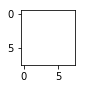

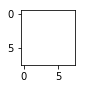

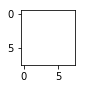

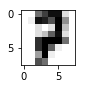

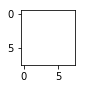

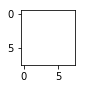

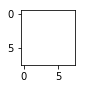

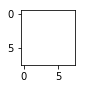

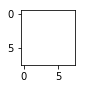

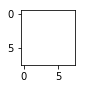

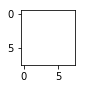

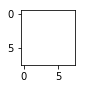

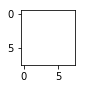

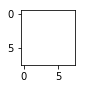

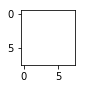

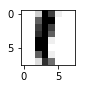

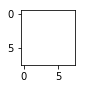

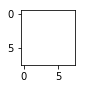

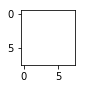

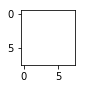

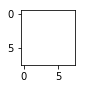

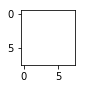

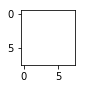

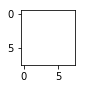

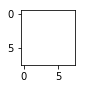

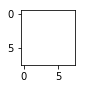

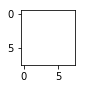

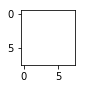

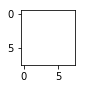

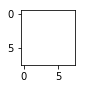

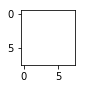

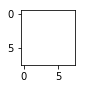

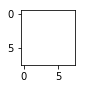

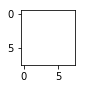

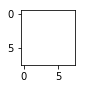

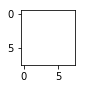

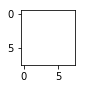

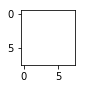

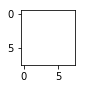

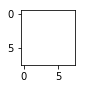

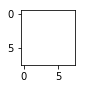

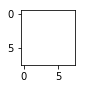

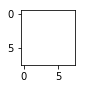

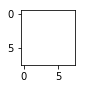

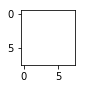

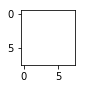

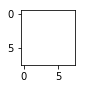

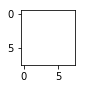

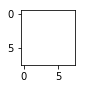

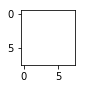

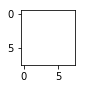

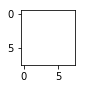

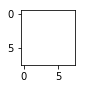

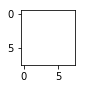

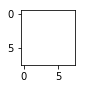

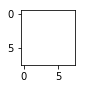

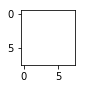

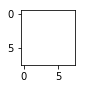

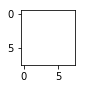

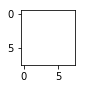

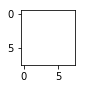

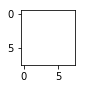

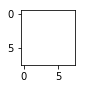

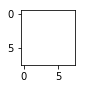

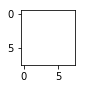

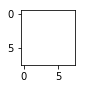

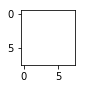

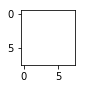

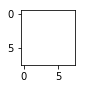

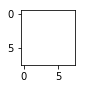

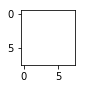

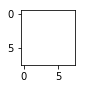

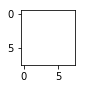

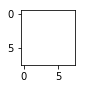

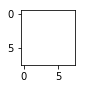

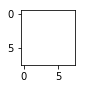

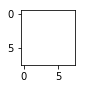

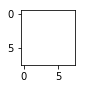

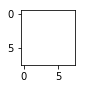

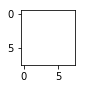

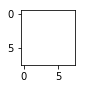

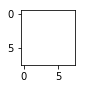

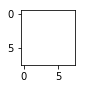

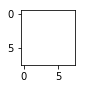

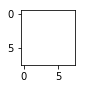

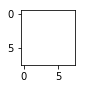

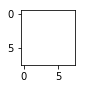

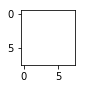

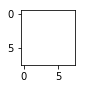

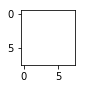

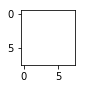

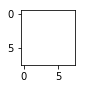

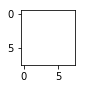

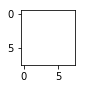

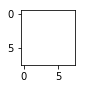

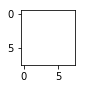

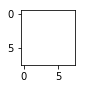

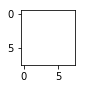

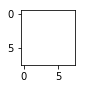

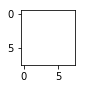

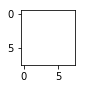

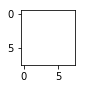

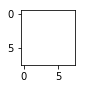

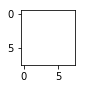

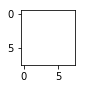

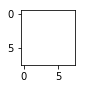

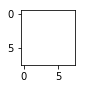

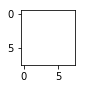

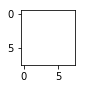

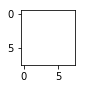

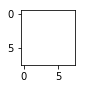

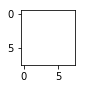

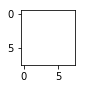

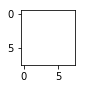

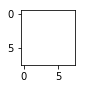

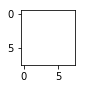

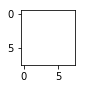

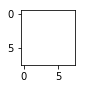

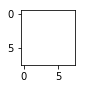

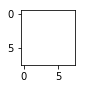

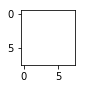

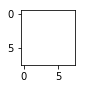

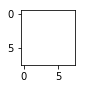

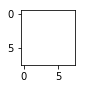

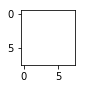

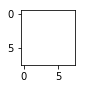

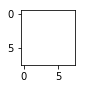

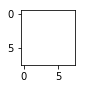

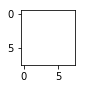

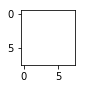

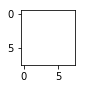

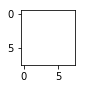

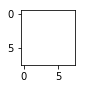

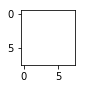

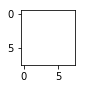

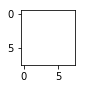

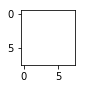

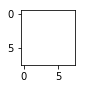

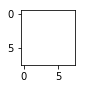

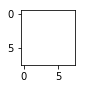

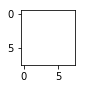

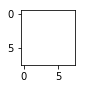

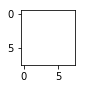

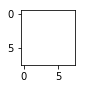

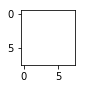

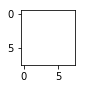

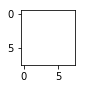

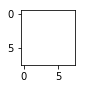

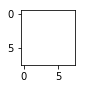

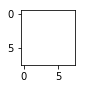

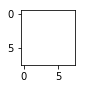

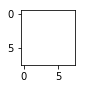

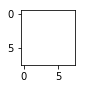

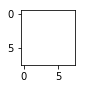

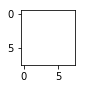

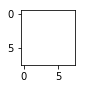

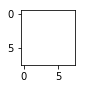

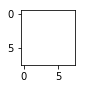

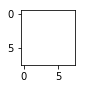

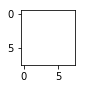

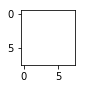

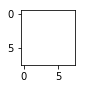

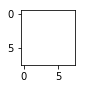

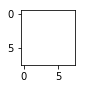

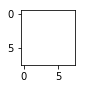

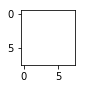

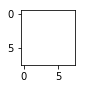

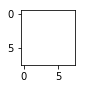

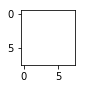

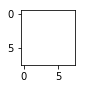

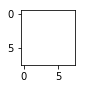

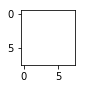

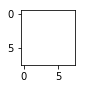

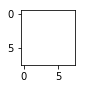

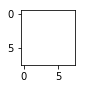

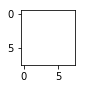

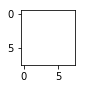

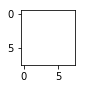

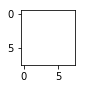

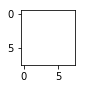

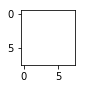

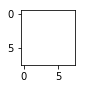

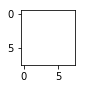

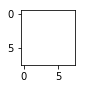

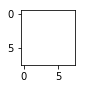

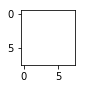

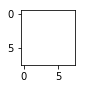

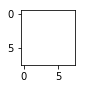

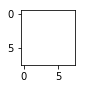

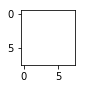

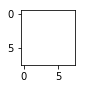

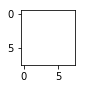

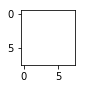

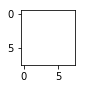

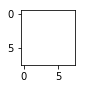

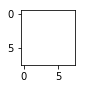

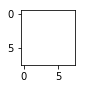



Mapa de clasificacion
Dibujando ...


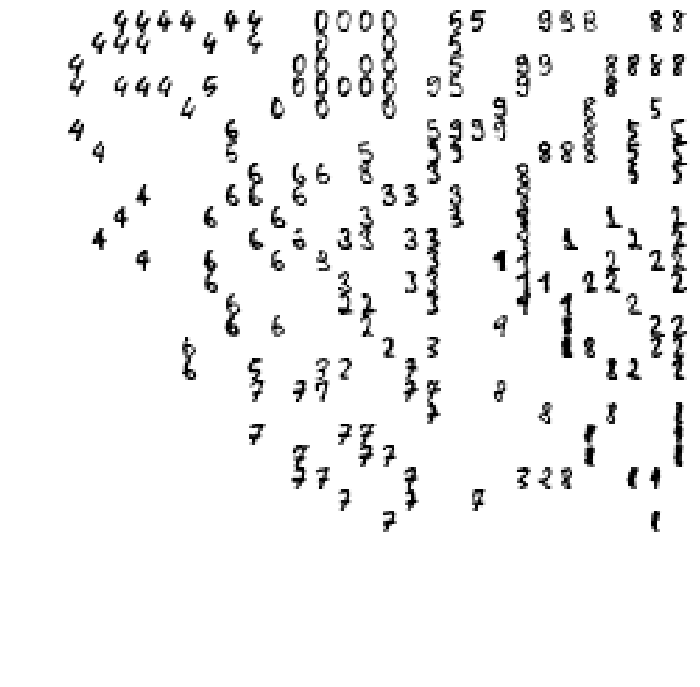

In [14]:
# Clasifica nuevos patrones.

# Inicializamos las variables.
# Definimos dos matrices y las inicializamos a 0.
mapa_de_activacion = np.zeros((lado_mapa, lado_mapa))
mapa_de_distancias = np.zeros((lado_mapa, lado_mapa))

distancia_media_patrones = [0] * num_entradas
cont_neuronas_activadas = 0

# Patrón de prueba que introducimos a la variable:
patrones_prueba = np.array([[  0,   0,   9,  15,  14,   2,   0,   0,   0,   0,   9,  3,   9,   8,   0,
   0,   0,   0,   0,   0,   6,  10,   0,   0,   0,   0,   0,  10,  15,   2,
   0,   0,   0,   0,   2,  10,  11,  15,   2,   0,   0,   3,   1,   0,   0,
  14,   4,   0,   0,  10,  13,   7,   2,  12,   4,   0,   0,   0,   7,  14,
  16,  10,   0,   0],

  [ 0,   0,   0,  0,  0,   0,   0,   0,   0,   0,   0,  0,   0,   0,   0,
   0,   0,   0,   0,   0,   0,  0,   0,   0,   0,   0,   0,  0,  0,   0,
   0,   0,   0,   0,   0,  0,  0,  0,   0,   0,   0,   0,   0,   0,   0,
  0,   0,   0,   0,  0,  0,   0,   0,  0,   0,   0,   0,   0,   0,  0,
  0,  0,   0,   0],

  [  0,   0,   3,  13,  13,   3,   0,   0,   0,   0,  14,   8,   7,  15,   1,
   0,   0,   3,  16,   0,   0,   9,   6,   0,   0,   6,  13,   0,   0,   4,
   8,   0,   0,   4,   9,   0,   0,   4,   8,   0,   0,   1,  13,   0,   0,
   5,   8,   0,   0,   0,  14,   7,   0,  11,   4,   0,   0,   0,   3,  15,
  16,  14,   0,   0],
                          
  [  0,   1,   6,  12,  15,   5,   0,   0,   0,   7,  14,  14,  16,   7,   0,
   0,   0,   0,   2,  14,  10,   0,   0,   0,   0,   0,  11,  16,   2,   0,
   0,   0,   0,   0,   2,  11,  16,  12,   0,   0,   0,   0,   0,   0,   4,
  14,   7,   0,   0,   0,   2,   4,   5,  14,   7,   0,   0,   0,   6,  16,
  14,   8,   0,   0],

  [  0,   0,  10,  12,  13,  16,   2,   0,   0,   4,  15,   6,   4,   4,   0,
   0,   0,   5,  10,   0,   0,   0,   0,   0,   0,   5,  16,  16,  16,   9,
   0,   0,   0,   2,  11,   3,   3,  12,   0,   0,   0,   0,   0,   0,   2,
  13,   0,   0,   0,   0,   4,   1,   9,  10,   0,   0,   0,   0,  16,  16,
  13,   1,   0,   0],

  [  0,   0,   4,  12,  13,   5,   0,   0,   0,   0,  14,  16,  16,  16,   4,
   0,   0,   6,  13,   2,   1,  11,   8,   0,   0,   6,  11,   0,   0,   8,
   8 ,  0,   0,   4,  16,   0,   0,  10,   8,   0,   0,   4,  16,   4,   8,
  16,   3,   0,   0,   0,  16,  16,  16,  12,   0,   0,   0,   0,   4,  15,
  14,   3,   0,   0]])


for i in range (0, len(patrones_prueba)):
    # Obtenemos el patron de la bmu ganadora y su posición en la matriz.
    bmu, bmu_idx = calcular_bmu(patrones_prueba[i], matriz_pesos, num_entradas)

    # Imprimimos las cordenadas (x, y) de la BMU para cada patrón de prueba.
    print('\nCoordenas de la BMU para el patrón de prueba ', patrones_prueba[i])
    print('x = ', bmu_idx[0])
    print('y = ', bmu_idx[1])

    # Calculamos un mapa con los sumatorios de distancias medias. ATENCION: este no es el mapa_de_distancias. 
    # Calculamos la distancia.
    distancia_media_patrones = sum((bmu - patrones_prueba[i])**2)
    # Guardamos la distancia calculada en un mapa de distancias, en el caso de que es esa posición ya hubiera guardada
    # una distancia anterior, sumariamos la distancia calculada a la que ya habia guardada en dicho mapa.
    mapa_de_distancias[bmu_idx[0], bmu_idx[1]] = mapa_de_distancias[bmu_idx[0], bmu_idx[1]] + distancia_media_patrones
    # Este mapa no es el verdadero mapa_de_distancias pero lo será cuando lo acabemos de calcular más adelante.

    # Calculamos el mapa de activacion.
    mapa_de_activacion[bmu_idx[0], bmu_idx[1]] += 1


# Una vez terminado el for, tenemos creado bien el mapa_de_activacion y podemos usarlo para hacer la media de nuestras
# distancias en el mapa_de_distancias.
# Mapa de distancias.
for x in range (0, len(matriz_pesos[:, 0])):
    for y in range (0, len(matriz_pesos[0, :])):
        if mapa_de_activacion[x][y] > 0:
            mapa_de_distancias[x][y] = mapa_de_distancias[x][y] / mapa_de_activacion[x][y]
            #Contamos las neuronas que han sido activadas.
            cont_neuronas_activadas = cont_neuronas_activadas + 1
        else:
            mapa_de_distancias[x][y] = 0        


# Imprimimos los mapas de activación y de distancias.
print('\n\nMapa de activacion: \n')
print(mapa_de_activacion)
print('\n\nMapa de distancias: \n')
print(mapa_de_distancias)

# Calculamos la distancia media del mapa (solo para aquellas neuronas activadas).
distancia_media_neuronas_activadas = sum(sum(mapa_de_distancias)) / cont_neuronas_activadas

# Imprimimos la distancia media.
print('\n\nDistancia media del mapa: ', distancia_media_neuronas_activadas)

print('\n\nDibujo de cada patron: ')
# Para pintar cada peso por separado.
for x in range (0,len(matriz_pesos[:, 0])):
    for y in range (0,len(matriz_pesos[0, :])):
        dibujar_digito(mapa_de_clasificacion[x, y])
        
# Dibujamos el mapa de clasificación.
print('\n\nMapa de clasificacion')
pintar_mapa(mapa_de_clasificacion)